In [1]:
import warnings
import logging
import os
import math
import glob

In [2]:
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [3]:
#tensorflow imports 
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, Callback, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Add, Dense, LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, Dropout, MultiHeadAttention, Layer, Embedding
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import Recall, Precision, AUC

#local package import 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

#local import 
from utils import sliding_window

In [6]:
def processing_act(mode = 'train', root_dir = 'dataset/SFDataset', data_type = 'watch_processed', new_len = 128, in_chan =3):
    fall = os.path.join(os.getcwd() , f'{root_dir}/{data_type}/{mode}/**/Fall/***.csv')
    adl = os.path.join(os.getcwd(), f'{root_dir}/{data_type}/{mode}/**/ADL/***.csv')
    fall_files = glob.glob(fall)
    adl_files = glob.glob(adl)
    all_file_path = fall_files + adl_files
    samples = len(all_file_path)
    dataset = np.zeros((1,new_len, in_chan))
    labels = []
    fall_pattern = re.compile("Fall")
    
    for file_path in all_file_path:
        label = None
        if fall_pattern.search(file_path):
            label = 1
        else:
            label = 0
        
        df = pd.read_csv(file_path)
        if not df.empty:
            df = df.loc[:,'DataCollection__w_accelerometer_x':'DataCollection__w_accelerometer_z']
            trial = df.to_numpy()
            act_len = trial.shape[0]
            channel = trial.shape[1]
            interpolated_data = interpolate(new_len, act_len, channel, trial)
            dataset = np.concatenate((dataset,interpolated_data), axis = 0)
            labels.append(label)
    return tf.convert_to_tensor(dataset[1:, :, :]), tf.convert_to_tensor(labels)

In [221]:
dataset , labels = processing_act(mode = 'val')
np.savez('dataset/SFDataset/val',data = dataset, labels = labels)

<tf.Tensor: shape=(38,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [85]:
def preprocessing(mode = 'train', root_dir = 'dataset/SmartFall',data_type = 'phone&watch', new_len = 128, in_chan = 3):
    fall = os.path.join(os.getcwd() , f'{root_dir}/{data_type}/{mode}/Fall/***.xlsx')
    adl = os.path.join(os.getcwd(), f'{root_dir}/{data_type}/{mode}/ADL/***.xlsx')
    fall_files = glob.glob(fall)
    adl_files = glob.glob(adl)

    all_file_path = fall_files + adl_files
    samples = len(all_file_path)
    dataset = np.zeros((1,new_len, in_chan))
    
    if len(all_file_path) == 0:
        raise Exception('Data files not found')
 
    trials_count = {}
    fall_pattern = re.compile("Fall")
    trials = []
    labels = []
    length = []
    #count = 0

    for file_path in all_file_path:
        print(file_path)
        label = None
        if fall_pattern.search(file_path):
            label = 1
        else:
            label = 0

        #checking if the excel has 2 sheets or not
        if len (pd.ExcelFile(file_path).sheet_names) == 2:
                df = pd.read_excel(file_path, sheet_name=-1)
                df = df.iloc[:, 12:15]
                null_col = df[df.isnull().any(axis = 1)].index.to_list()
                
                if len(null_col) % 10 != 0  :
                    print(f'{file_path} trimmed file contains {len(null_col)} of null rows')
                    continue
                elif len(null_col) == 0:
                    trial = df.to_numpy()
                    act_len = trial.shape[0]
                    channel = trial.shape[1]
                    interpolated_data = interpolate(new_len, act_len, channel, trial)
                    dataset = np.concatenate((dataset,interpolated_data), axis = 0)
                    labels.append(label)

                
                else:
                    #raise Exception(f'{file_path} trimmed file contains {len(null_col)} of null rows')
                    #calculating how many null segments we have 
                    null_col = df[df.isnull().any(axis = 1)].index.to_list()
                    print(null_col)
                    null_seg = len(null_col)//10


                    trial_start_lst = null_col[9::10]
                    trial_end_lst = null_col[10::10]

                    for i in range(len(null_col)//10 + 1):
                        #trials_count[label] = trials_count.get(label , 0) + 1
                        trial = None
                        if i == 0 :

                            #trial = df.iloc[0:null_col[1]-1, 3:6]
                            trial = df.iloc[0:null_col[1]-1, :]
                        elif i == null_seg :
                            #trial = df.iloc[trial_start_lst[-1]+1:, 3:6]
                            trial = df.iloc[trial_start_lst[-1]+1:, :]
                        else: 
                            trial_end = trial_end_lst[i-1]
                            trial_start = trial_start_lst[i-1] + 1
                            #trial = df.iloc[trial_start : trial_end-1 , 3:6]
                            trial = df.iloc[trial_start : trial_end-1, : ]
                            trial.dropna(inplace = True)

                        #trial = tf.convert_to_tensor(trial.values, dtype = tf.float32)
                        act_len = trial.shape[0]
                        channel = trial.shape[1]
                        trial = trial.to_numpy()
                        if trial.shape[0] == 0:
                            continue

                        else:
                            interpolated_data = interpolate(new_len, act_len, channel, trial)
                            dataset = np.concatenate((dataset,interpolated_data), axis = 0)
                            labels.append(label)

        else:
            raise Exception(f'{file_path} doesnt have trimmed data')
        
    return tf.convert_to_tensor(dataset[1:, :, :]), tf.convert_to_tensor(labels)

In [4]:
def interpolate(new_len, old_len, channel, data):
    x = np.linspace(1, old_len, num = new_len)
    xp = np.linspace(1, old_len, num = old_len)
    interpolated_data = np.zeros((1, new_len, channel))
    
    for idx in range(channel):
        yp = data[:, idx]
        axis_interpolated = np.interp(x, xp, yp)
        interpolated_data[0,:, idx] = axis_interpolated
    
    return interpolated_data

### Custom Metrics

In [4]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

### Learning Rate Scheduler

In [5]:
def cosine_schedule(base_lr, total_steps, warmup_steps ):
    def step_fn(epoch):
        lr = base_lr 
        progress = (epoch - warmup_steps) / float(total_steps -  warmup_steps)

        progress = tf.clip_by_value(progress, 0.0, 1.0)

        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))
        
        if warmup_steps:
            lr = lr * tf.minimum(1.0 , epoch/warmup_steps)
        
        return lr
    

    return step_fn

### Sliding Data into Windows

In [6]:
def get_positional_embedding(seq_len,d_model, n = 10000):
    P = np.zeros((seq_len, d_model))
    for k in range(seq_len):
        for i in np.arange(int(d_model/2)):
            denominator = np.power(n, 2*i/d_model)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i + 1] = np.cos(k/denominator)
    P = P[np.newaxis, : ,:]
    return tf.Variable(P,trainable = False ,dtype = tf.float32)

### Plot positional embedding

NameError: name 'postional_embedding' is not defined

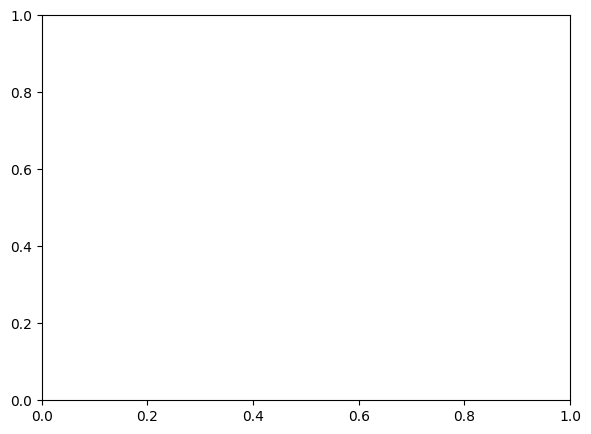

In [8]:
fig = plt.figure(figsize = (15,5))
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(postional_embedding, (512, 256))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)
    

In [7]:
def encoder(x, embed_dim,attn_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, length, channel):
    
    #attention_layer
    y = LayerNormalization(epsilon = 1e-6)(x)
    y = MultiHeadAttention(num_heads = num_heads,key_dim = attn_dim,dropout = attention_dropout_rate, kernel_initializer = TruncatedNormal(stddev = 0.02))(query = x,value = x,key = x,training = True)
    y = Dropout(rate = dropout_rate)(y)
    y = Add()([x,y])
    y = LayerNormalization(epsilon = 1e-6)(y)
    res = y
    
    
    #mlp_layer
    
    y = Dense(units = mlp_dim, kernel_initializer = TruncatedNormal(stddev = 0.02))(y)
    y = Dropout(rate = dropout_rate)(y)
    y = Conv1D(filters = x.shape[-1],kernel_size = 3,padding = "same")(y)
    y = Dropout(rate = dropout_rate)(y)
    y = Add()([res, y])
    y = LayerNormalization(epsilon = 1e-6)(y)
    
    return y
    
    

In [8]:
def transformer(length, channels,num_layers, embed_dim, attn_dim,mlp_dim, num_heads, dropout_rate, attention_dropout_rate):
    
    #initial normalization
    #pos_embed = get_positional_embedding(length, embed_dim)
    inputs= keras.Input(shape = (length, channels))
    x = inputs
    #x = Dense(embed_dim)(inputs)
    #x = Normalization()(inputs)
    #x = x + pos_embed
    #stacking encoder layers
    for _ in range(num_layers):
        x = encoder(x,embed_dim,attn_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, length,channels)
    #x = LayerNormalization(epsilon=1e-5)(x)
    

    
    for dim in [8, 16]:
        x = Dense(dim, activation = 'relu')(x)
        x = Dropout(dropout_rate)(x)
        
    #pooling
    x = GlobalAveragePooling1D(data_format = 'channels_first')(x)
    
    #output
    output = Dense(1, kernel_initializer="zeros", activation = 'sigmoid')(x)
    
    return keras.Model(inputs, output)

In [11]:
config = {
        'epochs': 50,
        'length':50,
        'channel':3,
        'num_layers':  2,
        'embed_layer_size': 16,
        'attention_head_dim' : 128,
        'global_clipnorm' : 3.0,
        'fc_layer_size': 32,
        'num_heads': 4,
        'dropout': 0.1,
        'attention_dropout': 0.0,
        'optimizer': 'adam',
        'amsgrad': False,
        'label_smoothing': 0.1,
        'learning_rate': 1e-3,
        #'weight_decay': {
        #    'values': [2.5e-4, 1e-4, 5e-5, 1e-5]
        'warmup_steps': 5,
        'batch_size': 32}

In [12]:
model = transformer(length = config['length'],
        channels=config['channel'],
        num_heads=config['num_heads'],
        dropout_rate = config['dropout'],
        attn_dim = config['attention_head_dim'],
        attention_dropout_rate = config['attention_dropout'],
        embed_dim =config['embed_layer_size'],
        mlp_dim = config['fc_layer_size'], 
        num_layers = config['num_layers'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 50, 3)        7683        input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 3)        0           multi_head_attention[0][0]       
______________________________________________________________________________________________

In [14]:
def process_data(file_path, window_size, stride):
    dataframe = pd.read_csv(file_path)
    dataset = dataframe[['w_accelerometer_x', 'w_accelerometer_y', 'w_accelerometer_z']].to_numpy()
    labels = dataframe['outcome'].to_numpy()
    data, labels= sliding_window(dataset, labels, window_size - 1,dataset.shape[0],window_size,stride)
    return data, labels

In [ ]:
C:\Users\bgu9\KD_Multimodal\new_watch_data_processed

### Loading data

In [16]:
train_dataset_path = os.path.join(os.getcwd(), 'new_watch_data_processed\\watch_train.csv')
val_dataset_path = os.path.join(os.getcwd(), 'new_watch_data_processed\\watch_val.csv')
window_size = 50
stride = 5

#processing train data 
X_train, y_train = process_data(train_dataset_path, window_size, stride)
#processing val data 
X_val , y_val = process_data(val_dataset_path, window_size, stride)

(15982, 50)
(5088, 50)


In [60]:
np.savez('dataset/sliding50_train', data = X_train, labels = y_train)

In [58]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 multi_head_attention_16 (Multi  (None, 50, 3)       7683        ['input_9[0][0]',                
 HeadAttention)                                                   'input_9[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 dropout_62 (Dropout)           (None, 50, 3)        0           ['multi_head_attention_16[0][0]']
                                                                                            

### Model training

In [ ]:
model.compile(
      loss= BinaryCrossentropy(label_smoothing=config['label_smoothing']),
      optimizer=Adam(
          global_clipnorm=config['global_clipnorm'],
          amsgrad=config['amsgrad'],
      ),
      metrics=[Recall(), Precision() , AUC(), F1_Score()],
    )
checkpoint_filepath = os.path.join(os.getcwd(), 'tmp/weights.ckpt')
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, 
                                      save_weights_only = True, 
                                      monitor = 'val_f1_score', 
                                      mode = 'max', 
                                      save_best_only = True, 
                                      verbose = True)
log_dir = "logs/"  # Specify the directory where TensorBoard logs will be saved
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(
      X_train,
      y_train,
      batch_size=config['batch_size'],
      epochs=config['epochs'],
      validation_data=(X_val, y_val),
      shuffle = True,
      callbacks=[
        LearningRateScheduler(cosine_schedule(base_lr=config['learning_rate'], total_steps=config['epochs'], warmup_steps=config['warmup_steps'])),
        #EarlyStopping(monitor="loss", mode='min', min_delta=0.001, patience=5),
        model_checkpoint, tensorboard_callback
      ],
      verbose=1
    )

Epoch 1/50


In [205]:
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Converting to tflite 

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [17]:
#adding special ops
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops. <-- Add this line
]
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True
converter.experimental_new_converter =True
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#converting to tflite 
tflite_model = converter.convert()

In [18]:
#writing the tflite model to a file 
with open('transformer_watch50.tflite', 'wb') as f:
    f.write(tflite_model)

In [21]:
#using interpreter to test
interpreter = tf.lite.Interpreter(model_path="transformer_watch50.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
#loading data
test_dataset_path = os.path.join(os.getcwd(), 'dataset/SFDataset/test.npz')
test_data = np.load(test_dataset_path)

X_test = test_data['data']
y_test = test_data['labels']

In [36]:
#reshaping data
data = X_test[11, :, :]
data = data[np.newaxis, :]

In [25]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [14]:
np.where(y_test == 1) 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [37]:
# Set input tensor to the interpreter
interpreter.set_tensor(input_details[0]['index'], data.astype(np.float32))

# Run inference
interpreter.invoke()

# Get the output tensor and post-process the results (example)
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Inference result:", output_data)

Inference result: [[0.70629865]]
